#Import Library

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV

# Modelling
from sklearn.linear_model import LinearRegression

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error,explained_variance_score,r2_score

# Saving
import pickle

# Load Dataset

In [106]:
jakarta_premium = pd.read_csv('https://raw.githubusercontent.com/FTDS-assignment-bay/p2-final-project-group-01-ftds-rmt-27/main/yogyakarta_premium.csv')

In [107]:
jakarta_premium['Tanggal'] = pd.to_datetime(jakarta_premium['Tanggal'], format="%Y/%m/%d")
jakarta_premium = jakarta_premium.set_index('Tanggal')['Harga']

In [108]:
import numpy as np

window = 5
X = []
y = []
for i in range(window,len(jakarta_premium)):
  if window+i<len(jakarta_premium):
    X.append(jakarta_premium[i:window+i].values.tolist())
    try:
      y.append(jakarta_premium[window+i])
    except:
      pass
  else:
    break

X = np.array(X)
y = np.array(y)

# Split Train, test set

In [109]:
train_size = round(len(X)*0.60)
X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

# Model Definition

In [110]:
poly_model = LinearRegression()

# Model Training

In [111]:
# define the pipeline
polynomial_pipeline = Pipeline([
    # step 1: convert X_train into polynomial features
    ('convert_to_poly_features',PolynomialFeatures()),
    # step 2: scale the newly made features
    ('scaler', MinMaxScaler()),
    # step 3: train the model
    ('polynomial_regressor', LinearRegression())
])

# define the parameters (check which polynomial feature degree suits best)
parameter_grid = {
    'convert_to_poly_features__degree':[2,4,6,8],
    'scaler' : [StandardScaler()],
}

# initialize GridSearchCV with 5 times cross validations, scoring criteria explained variance score
poly_grid_search = GridSearchCV(polynomial_pipeline, parameter_grid, cv =5, scoring = 'explained_variance')

# fit the model
poly_grid_search.fit(X_train, y_train)

# get the best polynomial degree and best estimator
best_poly_degree = poly_grid_search.best_params_['convert_to_poly_features__degree']
poly_best_estimator = poly_grid_search.best_estimator_

# print the results
print("Best polynomial degree: ", best_poly_degree)
print("Best estimator: ", poly_best_estimator)

Best polynomial degree:  2
Best estimator:  Pipeline(steps=[('convert_to_poly_features', PolynomialFeatures()),
                ('scaler', StandardScaler()),
                ('polynomial_regressor', LinearRegression())])


In [112]:
# fitting
poly_best_estimator.fit(X_train, y_train)

# predict the training set
y_pred_train_poly = poly_best_estimator.predict(X_train)

# Predict on the test set using the best estimator
y_test_pred_poly = poly_best_estimator.predict(X_test)


#Model Evaluation

In [113]:
print('Train MAE:',mean_absolute_error(y_train,y_pred_train_poly))
print('Train RMSE:',mean_squared_error(y_train,y_pred_train_poly, squared=False))
print('-----------------------------------------------------')
print('Test MAE:',mean_absolute_error(y_test,y_test_pred_poly))
print('Test RMSE:',mean_squared_error(y_test,y_test_pred_poly, squared=False))

Train MAE: 38.798539335911215
Train RMSE: 63.366725804561106
-----------------------------------------------------
Test MAE: 188.43465740356666
Test RMSE: 300.52005133699555


In [114]:
print("Train data explained variance regression score:", explained_variance_score(y_train,y_pred_train_poly))
print("Test data explained variance regression score:", explained_variance_score(y_test,y_test_pred_poly))

Train data explained variance regression score: 0.9363458650905209
Test data explained variance regression score: 0.8836886275089981


In [115]:
print("Train data R2 score:", r2_score(y_train,y_pred_train_poly))
print("Test data R2 score:", r2_score(y_test,y_test_pred_poly))

Train data R2 score: 0.9363458650905209
Test data R2 score: 0.8495167974194033


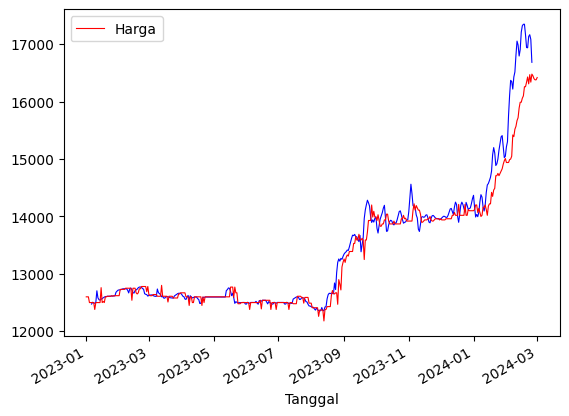

In [116]:
plt.plot(jakarta_premium.index[window:-window],np.append(y_pred_train_poly,y_test_pred_poly), color = 'blue',linewidth = 0.8)
jakarta_premium.plot(color='red', linewidth = 0.8)
plt.legend()
plt.show()

#Model Inference

In [117]:
# create forecasting function
def forecasting_function(jakarta_premium, month, best_estimator):
    jakarta_premium_forecast = jakarta_premium.copy()
    window = 5

    for i in range(month):
        X = jakarta_premium_forecast[-window:].values.reshape(1, -1)
        # Predict the next value using the best estimator and round it
        next_value = round(best_estimator.predict(X)[0])
        # Extract the last date and add one month to it
        last_date = jakarta_premium_forecast.index[-1]
        new_date = last_date + timedelta(days=30)  # Add one month (approximation)
        # Append the predicted value to the forecast series with the new date index
        jakarta_premium_forecast.loc[new_date] = next_value

    return jakarta_premium_forecast

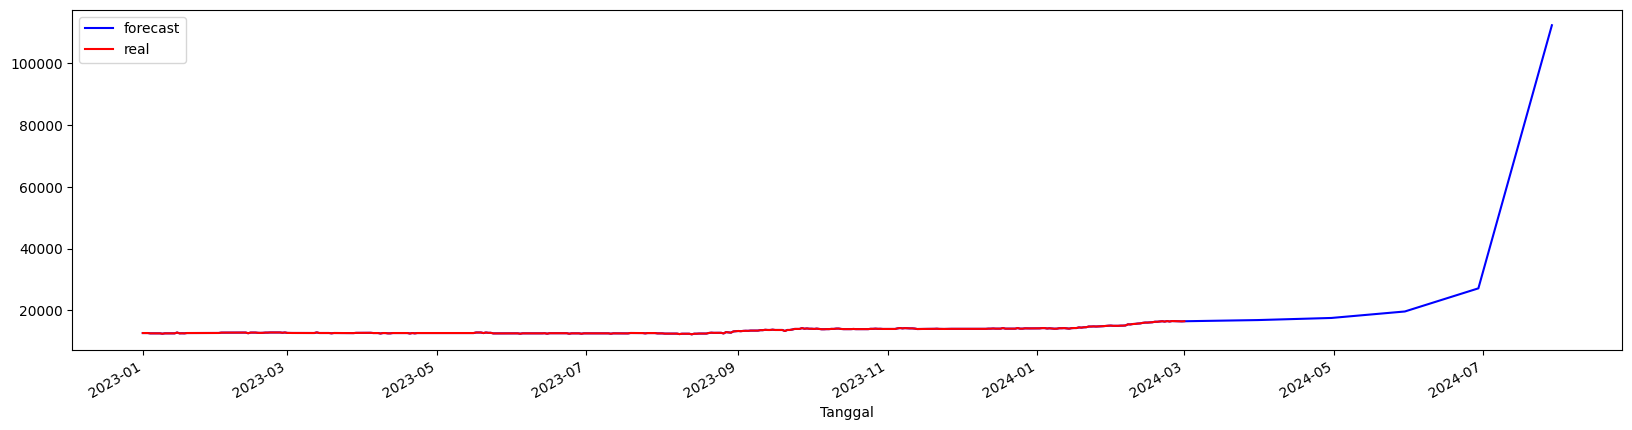

In [118]:
jakarta_premium_forecast_poly = forecasting_function(jakarta_premium, 5,poly_best_estimator)
jakarta_premium_forecast_poly.plot(color='blue',label='forecast',figsize=(20,5))
jakarta_premium.plot(color='red',label='real')
plt.legend()

#Model Saving

In [119]:
with open("yogyakarta.pkl", "wb") as f:
    pickle.dump(poly_best_estimator, f)